# toxic comments classification
## by Karin Brisker





### imports

In [143]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import re
import os
import time

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.optim as optim
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from flair.embeddings import WordEmbeddings

from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
import sklearn

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier

import warnings
warnings.filterwarnings('ignore')

sns.set(style="darkgrid")
sns.set_palette("pastel")

In [154]:
# load data
train_df = pd.read_csv('./Data/train.csv')
test_df = pd.read_csv('./Data/test.csv')
print('Train shape: ', train_df.shape)
print('Test shape: ', test_df.shape) 

Train shape:  (159571, 8)
Test shape:  (153164, 2)


In [125]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### visualization - count of each label 

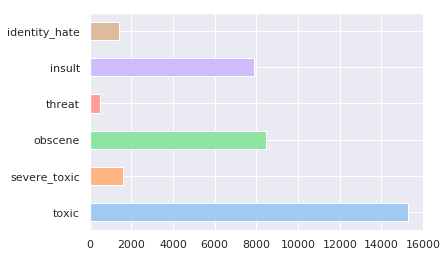

In [155]:
labels = list(train_df.columns[2:])

# y values
labels_data_train = train_df.iloc[:,2:]
labels_data_test = test_df.iloc[:,2:]

labels_count = labels_data_train.sum(axis = 0)
labels_count.plot(kind='barh')

### count of each label - sorted

In [156]:
pd.DataFrame(labels_count.sort_values(ascending=False), columns=['count'])

,count
toxic,15294
obscene,8449
insult,7877
severe_toxic,1595
identity_hate,1405
threat,478


### heatmap - correlation between labels

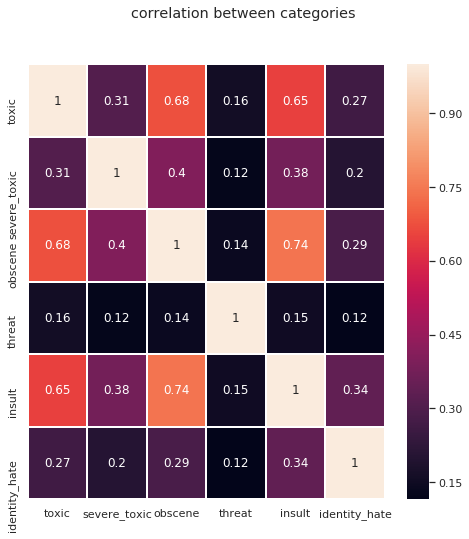

In [128]:
f, ax = plt.subplots(figsize=(8, 8))
f.suptitle('correlation between categories')
sns.heatmap(train_df[labels].corr(), annot=True, linewidths=.9, ax=ax)

### length of comment by class

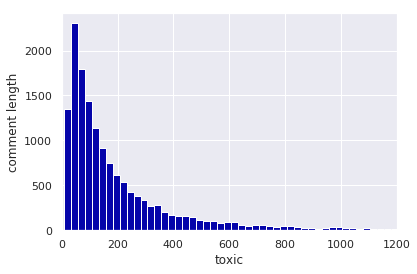

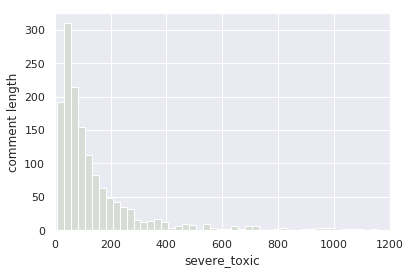

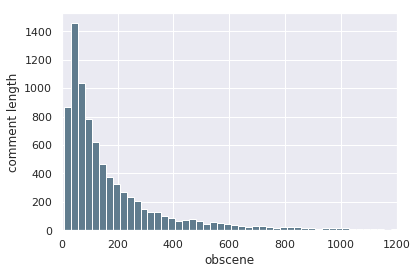

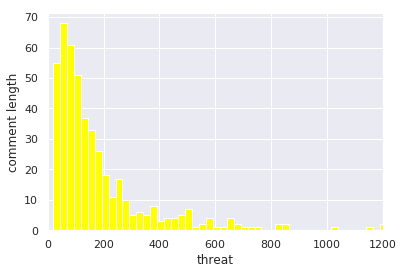

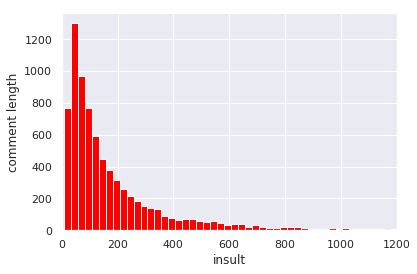

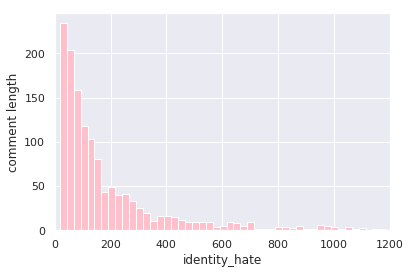

In [185]:
colors = ['#0504aa', '#d8dcd6', '#607c8e', 'yellow', 'red', 'pink']
i = 0
for label in labels:
    curr_df = train_df[train_df[label] == 1]
    text_length = curr_df['comment_text'].apply(lambda x: len(x))
    plt.hist(np.array(text_length), bins=200, color = colors[i])
    i += 1
    plt.ylabel('comment length')
    plt.xlabel(label)
    plt.xlim(right=1200)
    plt.xlim(left=0)
    plt.show()

#
#
### most frequent words by class, stop words -  removed
#
#

In [153]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

for label in labels:
    sub_train_df = train_df[train_df[label] == 1]["comment_text"]
    most_frequent = get_top_n_words(sub_train_df, 10)
    print(f' \n The most_frequent words in ## {label} ## comments are: \n')
    for word in most_frequent:
        print(f' word: "{word[0]}" count: {word[1]}')

 
 The most_frequent words in ## toxic ## comments are: 

 word: "fuck" count: 9938
 word: "wikipedia" count: 3686
 word: "shit" count: 3621
 word: "like" count: 3512
 word: "nigger" count: 3300
 word: "fucking" count: 3289
 word: "suck" count: 3235
 word: "ass" count: 2940
 word: "hate" count: 2631
 word: "just" count: 2481
 
 The most_frequent words in ## severe_toxic ## comments are: 

 word: "fuck" count: 7303
 word: "suck" count: 2535
 word: "ass" count: 2114
 word: "shit" count: 1884
 word: "faggot" count: 1571
 word: "fucking" count: 1456
 word: "die" count: 1156
 word: "bitch" count: 1113
 word: "nigger" count: 1012
 word: "sucks" count: 961
 
 The most_frequent words in ## obscene ## comments are: 

 word: "fuck" count: 9863
 word: "shit" count: 3212
 word: "fucking" count: 3192
 word: "suck" count: 3021
 word: "ass" count: 2847
 word: "nigger" count: 2727
 word: "wikipedia" count: 1911
 word: "bitch" count: 1795
 word: "like" count: 1541
 word: "cunt" count: 1531
 
 The most_

In [130]:
for label in labels:
    counts = train_df[label].value_counts()
    print(f' {label} : num of 1 labels {counts[1]} out of {counts[0]} ')

 toxic : num of 1 labels 15294 out of 144277 
 severe_toxic : num of 1 labels 1595 out of 157976 
 obscene : num of 1 labels 8449 out of 151122 
 threat : num of 1 labels 478 out of 159093 
 insult : num of 1 labels 7877 out of 151694 
 identity_hate : num of 1 labels 1405 out of 158166 


## cleaning text

In [131]:
def cleanData(text):    
    text = text.lower().split()
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+\-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

special_character_removal=re.compile(r'[^a-z\d ]',re.IGNORECASE)
replace_numbers=re.compile(r'\d+',re.IGNORECASE)

def text_to_wordlist(text):
    text = text.lower().split() 
    text = " ".join(text)
    text=special_character_removal.sub('',text)
    text=replace_numbers.sub('n',text)
    return(text)

In [132]:
train_df['comment_text'] = train_df['comment_text'].map(lambda x: cleanData(x))
test_df['comment_text'] = test_df['comment_text'].map(lambda x: cleanData(x))

list_sentences_train = train_df["comment_text"].fillna("NA").values
list_sentences_test = test_df["comment_text"].fillna("NA").values

train_df["comment_text"] = pd.Series([text_to_wordlist(text) for text in list_sentences_train])
test_df["comment_text"] = pd.Series([text_to_wordlist(text) for text in list_sentences_test])

In [133]:
y_train = train_df[labels].values
y_test = train_df[labels].values

In [134]:
cvec = CountVectorizer()
tvec = TfidfTransformer()

In [135]:
# cvec = we get a Bag of Word model that has cleaned the text, removing non-aphanumeric characters and stop words.
# bag_of_words a matrix where each row represents a specific text in corpus and each column represents a word 
# in vocabulary, that is, all words found in corpus. Note that bag_of_words[i,j] is the occurrence of word j in the text i.
X_train = tvec.fit_transform(cvec.fit_transform(train_df['comment_text']))
X_test = tvec.transform(cvec.transform(test_df["comment_text"]))

#
## models
#

In [139]:
models = {'MultinomialNB':MultinomialNB(), 'XGBClassifier': XGBClassifier(), 'LogisticRegression':LogisticRegression(), 'SGDClassifier':SGDClassifier()}

In [144]:
for model in models.keys():
    print('\n ############# \n')
    print(f'\n {model} results: \n')
    accuracies = [[], [], []]
    for category in labels:
        models[model].fit(X_train, train_df[category])
        accuracy = models[model].score(X_train, train_df[category])
        accuracies[0].append(accuracy)
        print(f"Accuracy For {category} Class Is {round(accuracy*100,2)}%")


 ############# 


 MultinomialNB results: 

Accuracy For toxic Class Is 92.47%
Accuracy For severe_toxic Class Is 98.99%
Accuracy For obscene Class Is 95.43%
Accuracy For threat Class Is 99.7%
Accuracy For insult Class Is 95.39%
Accuracy For identity_hate Class Is 99.11%

 ############# 


 XGBClassifier results: 

Accuracy For toxic Class Is 94.15%
Accuracy For severe_toxic Class Is 99.13%
Accuracy For obscene Class Is 97.5%
Accuracy For threat Class Is 99.78%
Accuracy For insult Class Is 96.81%
Accuracy For identity_hate Class Is 99.28%

 ############# 


 LogisticRegression results: 

Accuracy For toxic Class Is 96.23%
Accuracy For severe_toxic Class Is 99.13%
Accuracy For obscene Class Is 97.96%
Accuracy For threat Class Is 99.73%
Accuracy For insult Class Is 97.4%
Accuracy For identity_hate Class Is 99.24%

 ############# 


 SGDClassifier results: 

Accuracy For toxic Class Is 94.55%
Accuracy For severe_toxic Class Is 99.0%
Accuracy For obscene Class Is 97.48%
Accuracy For threa

# Deep learning models
### load embeddings (pretrained - glove)
### 100 D

In [ ]:
embeddings_list = []
embeddings = {}
f = open('./Data/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    value = torch.tensor(np.asarray(values[1:], dtype='float32'))
    embeddings[word] = value
    embeddings_list.append(value)
f.close()

vocab_size = len(embeddings.keys())
idx2word = dict(enumerate(embeddings.keys()))
word2idx = dict(zip(idx2word.values(), idx2word.keys()))

embeddings_vectors = torch.stack(embeddings_list)

### models parameters

In [189]:
import argparse

parser = argparse.ArgumentParser(description='toxic_comments_classification Model')

parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
parser.add_argument('--clip', type=float, default=0.25, help='gradient clipping')
parser.add_argument('--epochs', type=int, default=1000, help='upper epoch limit')
parser.add_argument('--batch_size', type=int, default=256, metavar='N', help='batch size')
parser.add_argument('--seed', type=int, default=1234, help='random seed')
parser.add_argument('--wdecay', type=float, default=5e-5, help='weight decay applied to all weights')
parser.add_argument('--save', type=str, default='toxic_comments_classification.pt', help='path to save the final model')
parser.add_argument('--logging_output', type=str, default='', help='logging output file name')
parser.add_argument('--dropout', type=float, default=0.5, help='the probability for dropout [default: 0.5]')
parser.add_argument('--max-norm', type=float, default=3.0, help='l2 constraint of parameters [default: 3.0]')
parser.add_argument('--kernel_num', type=int, default=50, help='number of each kind of kernel')
parser.add_argument('--kernel_sizes', type=str, default='3,4,5', help='comma-separated kernel sizes for convolution')

args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--lr LR] [--clip CLIP] [--epochs EPOCHS]
                             [--batch_size N] [--seed SEED] [--wdecay WDECAY]
                             [--save SAVE] [--logging_output LOGGING_OUTPUT]
                             [--dropout DROPOUT] [--max-norm MAX_NORM]
                             [--kernel_num KERNEL_NUM]
                             [--kernel_sizes KERNEL_SIZES]
ipykernel_launcher.py: error: unrecognized arguments: -f /run/user/1000/jupyter/kernel-2266db7d-8ee6-4daa-b382-47dd45d2ffff.json


SystemExit: 2

In [ ]:
train_df['comment_text'] = train_df['comment_text'].map(lambda x: cleanData(x))

list_sentences_train = train_df["comment_text"].fillna("NA").values
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train_df[list_classes].values
list_sentences_test = test_df["comment_text"].fillna("NA").values

comments = []
for text in tqdm(list_sentences_train):
    comments.append(text_to_wordlist(text))

train_df['comment_text'] = pd.Series(comments)

test_comments = []
for text in list_sentences_test:
    test_comments.append(text_to_wordlist(text).strip())

In [194]:
def get_batch(data):
    remainder = len(data) % batch_size
    for j in range(0, len(data) - remainder, batch_size):
        batch_data = data[j:j + batch_size, :]
        yield batch_data
    if remainder > 0:
        yield data[j:, :]


def clip_gradient(model, clip_value):
    params = list(filter(lambda p: p.grad is not None, model.parameters()))
    for p in params:
        p.grad.data.clamp_(-clip_value, clip_value)


def train_model(model, data, epoch):
    total_epoch_loss = 0
    model.to(device)
    np.random.shuffle(data)
    optim = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=args.lr)
    steps = 0
    model.train()
    my_generator = get_batch(data)
    batches_range = int((len(data) - 1) / batch_size)
    for iter in tqdm(range(batches_range)):
        batch = next(my_generator)
        comments = batch[:, 1]
        words = []
        for comment in comments:
            words.append(torch.tensor([word2idx[word] for word in comment.strip().split() if word in word2idx.keys()]))
        targets = torch.autograd.Variable(torch.tensor(np.array(batch[:, 2:]).astype('float16'))).long().to(device)
        optim.zero_grad()
        prediction = model(torch.stack(words).to(device), 1)
        loss = loss_fn(torch.tensor(prediction, requires_grad=True).to(device), targets.to(device).float())
        loss.backward()
        clip_gradient(model, args.clip)
        optim.step()
        steps += 1
        total_epoch_loss += loss.item()
    return total_epoch_loss / steps


def accuracy(logits, labels):
    """
    calculate the accuracy
    :param logits: Variable [batch_size, ]
    :param labels: Variable [batch_size]
    :return:
    """
    logits = torch.tensor(logits).data
    labels = labels.data
    logits[logits > .5] = 1
    logits[logits <= .5] = 0

    return torch.mean((logits.long() == labels.cpu().long()).type(torch.cuda.FloatTensor))


def eval_model(model, data):
    total_epoch_loss = 0
    total_epoch_acc = 0
    model.eval()
    steps = 0
    batches_range = int((len(data) - 1) / batch_size)
    for iter in tqdm(range(batches_range)):
        batch = next(my_generator)
        comments = batch[:, 1]
        words = []
        for comment in comments:
            words.append(torch.tensor([word2idx[word] for word in comment.strip().split() if word in word2idx.keys()]))
        targets = torch.autograd.Variable(torch.tensor(np.array(batch[:, 2:]).astype('float16'))).long().to(device)
        prediction = model(torch.stack(words).to(device), 1)
        loss = loss_fn(torch.tensor(prediction, requires_grad=True).to(device), targets.to(device).float())
        total_epoch_loss += loss.item()
        steps += 1

    return total_epoch_loss / steps

In [193]:
class LSTM_model(nn.Module):
    def __init__(self, batch_size, output_size, hidden_size, vocab_size, embedding_length, embeddings_vectors):
        super(LSTM_model, self).__init__()
        self.batch_size = batch_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.embedding_length = embedding_length
        self.embed = nn.Embedding(vocab_size, embedding_length)
        self.embed.weight.data.copy_(embeddings_vectors)
        # not to update glove
        self.embed.weight.requires_grad = False
        for p in self.embed.parameters():
            if p.requires_grad:
                p.requires_grad = False
        self.lstm = nn.LSTM(embedding_length, hidden_size)
        self.label = nn.Linear(hidden_size, output_size)

    def forward(self, input_sen, batch_size):
        embeded = self.embed(input_sen)  # (batch_size, sen_len,  embedding_length)
        embeded = embeded.permute(1, 0, 2)  # (sen_len, batch_size, embedding_length)
        if batch_size is None:
            h_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())  # Initial hidden state
            c_0 = Variable(torch.zeros(1, self.batch_size, self.hidden_size).cuda())  # Initial cell state
        else:
            h_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
            c_0 = Variable(torch.zeros(1, batch_size, self.hidden_size).cuda())
        output, (last_hidden_state, final_cell_state) = self.lstm(embeded, (h_0, c_0))
        curr_output = self.label(last_hidden_state[-1])  
        # last_hidden_state = (1, batch_size, hidden_size) 
        # final_output = (batch_size, output_size)
        return curr_output

In [192]:
class CNN_classifier(nn.Module):
    def __init__(self, batch_size, output_size, in_channels, out_channels, kernels, stride, padding, keep_probab,
                 vocab_size, embedding_length, weights):
        super(CNN_classifier, self).__init__()
        self.batch_size = batch_size
        self.output_size = output_size
        self.kernels = kernels
        self.stride = stride
        self.padding = padding
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.vocab_size = vocab_size
        self.embedding_length = embedding_length
        self.embed = nn.Embedding(vocab_size, embedding_length)
        self.embed.weight.data.copy_(embeddings_vectors)
        # not to update glove
        self.embed.weight.requires_grad = False
        for p in self.embed.parameters():
            if p.requires_grad:
                p.requires_grad = False
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(kernels[0], embedding_length))
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(kernels[1], embedding_length))
        self.conv3 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(kernels[2], embedding_length))
        self.dropout = nn.Dropout(keep_probab)
        self.last_linear = nn.Linear(len(kernels) * out_channels, output_size)

    def conv_and_pool(self, input, conv_layer):
        conv_out = conv_layer(input) 
        activation = F.relu(conv_out.squeeze(3))
        max_out = F.max_pool1d(activation, activation.size()[2]).squeeze(2)
        return max_out

    def forward(self, sentences, batch_size=None):
        embedded = self.embed(sentences)
        embedded = embedded.unsqueeze(1) # (batch_size, 1, sen_len, embedding_length)
        max_out1 = self.conv_and_pool(embedded, self.conv1)
        max_out2 = self.conv_and_pool(embedded, self.conv2)
        max_out3 = self.conv_and_pool(embedded, self.conv3)

        all_out = torch.cat((max_out1, max_out2, max_out3), 1)
        # (batch_size, num_kernels*out_channels)
        fc = self.dropout(all_out)
        # (batch_size, num_kernels*out_channels)
        logits = self.last_linear(fc)

        return logits

In [ ]:
learning_rate = args.lr
batch_size = 1
output_size = 6
hidden_size = 256
embedding_length = 100

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = LSTM_model(batch_size, output_size, hidden_size, vocab_size, embedding_length, embeddings_vectors).to(device)

# good loss for multilabel classification
loss_fn = nn.BCEWithLogitsLoss().to(device)

for epoch in range(args.epochs):
    start = time.time()
    train_loss = train_model(model, train_df.values, epoch)
    print('  - (Training)   loss: {loss: 8.5f}, ' 'elapse: {elapse:3.3f} min'.format(
        loss=train_loss,
        elapse=(time.time() - start) / 60))

test_loss = eval_model(model, test_iter)
print(f'Test Loss: {test_loss:.3f}')